In [1]:
1+1

2

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_community.document_loaders import Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 200,
)

loader = Docx2txtLoader("./tax.docx")
document_list = loader.load_and_split(text_splitter=text_splitter)

In [4]:
from langchain_openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings(model="text-embedding-3-large")

In [5]:
from langchain_chroma import Chroma

# vector_store = Chroma.from_documents(
#     documents=document_list,
#     embedding=embedding,
#     collection_name="chroma_tax",
#     persist_directory="./chroma_tax"
# )

vector_store = Chroma(
    collection_name="chroma_tax",
    embedding_function=embedding,
    persist_directory="./chroma_tax"
)

In [6]:
retriever = vector_store.as_retriever(search_kwargs={"k" : 3})
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x00000239A673A790>, search_kwargs={'k': 3})

In [7]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]     #retriever에 있는 문서에서 읽어오겠다
    answer : str
    
graph_builder = StateGraph(AgentState)

In [8]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다. 
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state
        
    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}        #크로마디비에서 검색된 문서 


    

In [9]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [10]:
from langchain import hub

generate_prompt = hub.pull('rlm/rag-prompt')

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    
    context = state['context']
    query = state['query']
    
    rag_chain = generate_prompt | llm
    
    response = rag_chain.invoke({
        'question': query,
        'context' : context,
    })
    
    return {'answer': response}

c:\AI_Prompt\workspace\ai_agent_work2\langgraph_uv\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [11]:
from langchain import hub
from typing import Literal

#문서 관련성 체크 
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

#분기문. 특정 노드 언급이 제일 좋음. 
def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다. 
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.
        
    Returns: 
        Literal['generate', 'rewrite']: 문서가 관련성이 높으면 'generate', 그렇지 않으면 'rewrite'를 반환합니다.
        
    
    """
    
    query = state['query']
    context = state['context']
    
    doc_relevance_chain = doc_relevance_prompt | llm 
    
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    
    if response['Score'] == 1:
        return 'generate'
    
    return 'rewrite'
    
    

c:\AI_Prompt\workspace\ai_agent_work2\langgraph_uv\.venv\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [12]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ["사람과 관련된 표현 -> 거주자"]

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
사전: {dictionary}
질문: {{query}}     
""")
#f-string사용해서 {}한번 더 해줘야함. 
def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 고려하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다. 
    """
    
    query = state['query']
    #chain
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()        
                                            #전체를 str로 반환. 이게 다시 질문이 되야하기 때문
    
    response = rewrite_chain.invoke({'query': query})
    
    return {'query': response}

In [13]:
#node
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)



In [14]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)



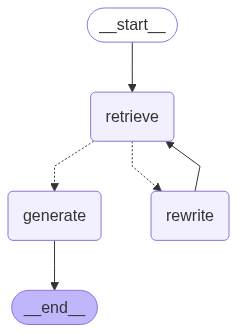

In [15]:
from IPython.display import Image, display
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
initial_state = {'query': '연봉 5천만원 직장인의 소득세는?'}
graph.invoke(initial_state)

{'query': '거주자의 연봉 5천만원에 대한 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './tax.docx'}, page_content='③ 제1항 및 제2항에 따른 이자등 상당액의 계산방법과 그 밖에 필요한 사항은 대통령령으로 정한다.\n\n[전문개정 2009. 12. 31.]\n\n\n\n제46조(채권 등에 대한 소득금액의 계산 특례) ① 거주자가 제16조제1항제1호ㆍ제2호ㆍ제2호의2ㆍ제5호 및 제6호에 해당하는 채권 또는 증권과 타인에게 양도가 가능한 증권으로서 대통령령으로 정하는 것(이하 이 조, 제133조의2 및 제156조의3에서 “채권등”이라 한다)의 발행법인으로부터 해당 채권등에서 발생하는 이자 또는 할인액(이하 이 조, 제133조의2 및 제156조의3에서 “이자등”이라 한다)을 지급[전환사채의 주식전환, 교환사채의 주식교환 및 신주인수권부사채의 신주인수권행사(신주 발행대금을 해당 신주인수권부사채로 납입하는 경우만 해당한다) 및 「자본시장과 금융투자업에 관한 법률」 제4조제7항제3호ㆍ제3호의2 및 제3호의3에 해당하는 채권등이 주식으로 전환ㆍ상환되는 경우를 포함한다. 이하 같다]받거나 해당 채권등을 매도(증여ㆍ변제 및 출자 등으로 채권등의 소유권 또는 이자소득의 수급권의 변동이 있는 경우와 매도를 위탁하거나 중개 또는 알선시키는 경우를 포함하되, 환매조건부채권매매거래 등 대통령령으로 정하는 경우는 제외한다. 이하 제133조의2에서 같다)하는 경우에는 거주자에게 그 보유기간별로 귀속되는 이자등 상당액을 해당 거주자의 제16조에 따른 이자소득으로 보아 소득금액을 계산한다. <개정 2010. 12. 27., 2012. 1. 1., 2020. 12. 29.>\n\n② 제1항을 적용할 때 해당 거주자가 해당 채권등을 보유한 기간을 대통령령으로 정하는 바에 따라 입증하지 못하는 경우에는 제133조의2제1항에 따른 원천징수기간의 이자등 상당액이 해당 거주자에게 귀속되는 것으로 보아 소득금액을 계산